




# Projet Fil Rouge 2023 : Reconnaissance de commandes audio


**Noms :**

**Prénoms :**

**Nom du binôme :**




Ces 12 séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="DroneJS.JPG" width="600" height="500"  >



Ces séances se décomposent en ces parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import librosa
from os import listdir
from os.path import isfile, join
import glob
import re

# Partie I : Prétraitement des données 

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 


In [3]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')


The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


### We trim the recordings to isolate the word and have identical durations
The smallest record contains 18 522 samples. We are going to cut all recordings to be of this size.

In [4]:

def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [5]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


### Spectral representation

1. Apply a Fourrier transform on the signals in $X$ using the function fft of scipy. Explain why the resulting dimension is too large to apply logistic regression.

In [6]:
from scipy import signal
from scipy.fft import fft

In [7]:
X_hat = fft(X, axis=1)
X_hat.shape

(54, 18522)

Since the number of variables (columns) are way higher than the number of samples (rows), the estimations of the parameters will not be accurate. $p >> n$

2. Let $\hat{X}$ be the fourier transform of $X$. Apply a PCA on $|\hat{X}|$ and plot the total explained variance in function of the numer of components.

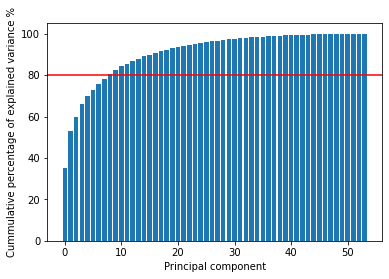

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_pca = PCA().fit(StandardScaler().fit_transform(np.abs(X_hat)))

plt.bar(np.arange(X_pca.n_components_), np.cumsum(X_pca.explained_variance_ratio_ * 100))
plt.xlabel("Principal component")
plt.ylabel("Cummulative percentage of explained variance %")
plt.axhline(y=80, color="r")

We choose the number of component such as 80% of the variance is explained : 10.

3. Apply a Short Term Fourier Transform on $X$. What are the dimension of stft $\hat{X}[t,f]$?
$\newline$
Make 2 subplots (3x3) of the stft (as images with function .imshow()) with three instances of each words, one for male and one for female 

The dimensions of $\hat{X}[t,f]$ are (127, 147)

(127, 147)


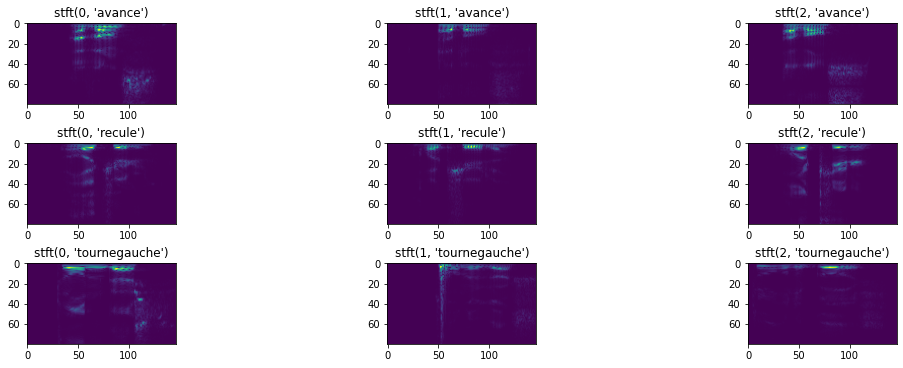

In [9]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'stft{instance,word}')

        
print(Zxx.shape)
plt.show()

### Now we will build sklearn transformers to extract features

Create a class STFT in the same spirit as FFT. 
Add a first argument to choose between returning different statistics (mean, quantile, max...) along time such that each signal. Add a second argument that gives the maximum frequency index 

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

In [11]:
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation        
        return np.absolute(fft(X)[:, :self.idx_frequence_max])

In [12]:
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, statistic=None, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
        self.statistic = statistic
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation
        _, _, stft_ = signal.stft(X, axis=1)
        stft_norm = np.absolute(stft_[:, :self.idx_frequence_max, :])
        return self.statistic(stft_norm, axis=2)

In [13]:
fft_ = FFT(idx_frequence_max=55)
X_fft = fft_.transform(X)
X_stft = STFT(np.mean, idx_frequence_max=55).transform(X)

X_fft.shape

(54, 55)

##### Stft will be used as pretreatment in the rest of the notebook. Stft allows to extract the features (spectral) and reduce the dimensionality of the data in our machine learning problem. 

In [14]:
import random


def augment_sound_samples(sound_samples, labels, num_augmentations=3):
    augmented_samples = []
    augmented_labels = []

    for sample, label in zip(sound_samples, labels):
        augmented_samples.append(sample)
        augmented_labels.append(label)

        for _ in range(num_augmentations):
            augmented_sample = sample.copy()

            # Randomly apply one of the augmentation techniques
            augmentation_func = random.choice([
                pitch_shift,
                noise_injection,
                time_shift
            ])
            augmented_sample = augmentation_func(augmented_sample)

            augmented_samples.append(trim(augmented_sample))
            augmented_labels.append(label)
    return np.array(augmented_samples), np.array(augmented_labels)

# Pitch shift augmentation
def pitch_shift(sample):
    pitch_shift_amount = np.random.randint(-4, 4)  # Randomly shift pitch by -4 to +4 semitones
    return librosa.effects.pitch_shift(sample, sr=22050, n_steps=pitch_shift_amount)

# Noise injection augmentation
def noise_injection(sample):
    noise = np.random.normal(0, 0.02, len(sample))  # Add Gaussian noise with a standard deviation of 0.02
    return sample + noise

# Time shift augmentation
def time_shift(sample):
    time_shift_amount = np.random.randint(-2205, 2205)  # Randomly shift time by -0.1s to +0.1s (assuming sr=22050)
    return np.roll(sample, time_shift_amount)

# Partie II : Sélection de variables et pénalisation

### 1. Multiclass regression


Apply a **multiclass regression** model.

We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.

### Objective

Try to apply a logistic regression with **Leave one out Cross validation** on :

1. The first PCA components of FFT (try multiple "n_compenents")
2. Different statistics and maximum frequency of the STFT
3. The same as before with scaling

In each situations try different regularization coefficient C.

To simplify use the **pipeline** function of sklearn. You can also use the function **GridSearchCV** with cv = X.shape[0] to vary the parameters of preprocessing and logistic regression. You can acess to all results with "cv_results_"



In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, y_train = augment_sound_samples(X_train, y_train, 3)

With our 10 first principal components (in order to have at least 80% of explained variance) of the fft transform, we tried to optimize the hyperparameters of our first Logistic Regression. To reduce the time of computing, we optimized our hyperparameters one at a time, even though the resulting parameters might not be overall optimal.
$\newline$
We then did the same for different pre treatment and we compared it.

In [17]:
print(X_train.shape)
print(y_train.shape)


(172, 18522)
(172,)


In [18]:
fourier_transform = FFT()
pca = PCA()
regression = LogisticRegression(max_iter=10000)
params = {
    "pca__n_components": [10],
    "regression__C": [0.01],
    "regression__solver": ["lbfgs"], # after testing all available solvers
    "regression__multi_class": ["ovr"], # after testing multinomial vs ovr
    "fft__idx_frequence_max": [650]
    }
pipeline = Pipeline(steps = [('fft', fourier_transform), ('pca', pca), ('regression', regression)])
clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

model = clf.fit(X_train, y_train)

In [19]:
print(clf.best_params_)
print(clf.best_score_)
model_fft_no_scale = clf.best_estimator_

{'fft__idx_frequence_max': 650, 'pca__n_components': 10, 'regression__C': 0.01, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs'}
0.8023255813953488


In [20]:
# We normalize our data here
fourier_transform = FFT()
scaler = StandardScaler()
pca = PCA()
regression = LogisticRegression(max_iter=10000)
params = {
    "pca__n_components":[10], # after testing range(4, 16, 2)
    "regression__C": [0.01],
    "regression__solver": ["lbfgs"], # after testing all available solvers
    "regression__multi_class": ["ovr"], # after testing multinomial vs ovr
    "fft__idx_frequence_max": [650]
    }
pipeline = Pipeline(steps = [("scaler", scaler), ('fft', fourier_transform), ('pca', pca), ('regression', regression)])
clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

model = clf.fit(X, y)


In [21]:
print(model.best_params_)
print(model.best_score_)
model_fft_with_scale = clf.best_estimator_

{'fft__idx_frequence_max': 650, 'pca__n_components': 10, 'regression__C': 0.01, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs'}
0.7777777777777778


In [22]:
# This cell takes 20s to compute
# With stft pretreatment
fourier_transform = STFT()
regression = LogisticRegression(max_iter=10000)
params = {
    "regression__C": [10],
    "regression__solver": ["lbfgs"], # after testing all available solvers
    "regression__multi_class": ["ovr"], # after testing multinomial vs ovr
    "stft__statistic": [np.max],
    "stft__idx_frequence_max":np.arange(20,100,5),
    }
pipeline = Pipeline(steps = [('stft', fourier_transform), ('regression', regression)])
clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), verbose=1, n_jobs=-1)

model = clf.fit(X, y)

Fitting 54 folds for each of 16 candidates, totalling 864 fits


In [23]:
print(clf.best_params_)
print(clf.best_score_)
model_stft_no_scale = clf.best_estimator_

{'regression__C': 10, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs', 'stft__idx_frequence_max': 75, 'stft__statistic': <function amax at 0x7f4928107d90>}
0.48148148148148145


In [24]:
# We normalize the data from stft
fourier_transform = STFT()
scaler = StandardScaler()
regression = LogisticRegression(max_iter=10000)
params = {
    "regression__C": [10], # after testing np.logspace(-3, 1, 20)
    "regression__solver": ["lbfgs"], # after testing all available solvers
    "regression__multi_class": ["ovr"], # after testing multinomial vs ovr
    "stft__statistic": [np.max],
    "stft__idx_frequence_max": [75],
    }
pipeline = Pipeline(steps = [('scaler', scaler), ('stft', fourier_transform), ('regression', regression)])
clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), verbose=1, n_jobs=-1)

model = clf.fit(X, y)

Fitting 54 folds for each of 1 candidates, totalling 54 fits


In [25]:
print(clf.best_params_)
print(clf.best_score_)
model_stft_with_scale = clf.best_estimator_


{'regression__C': 10, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs', 'stft__idx_frequence_max': 75, 'stft__statistic': <function amax at 0x7f4928107d90>}
0.7777777777777778


##  Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [26]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

accuracy :  0.9090909090909091


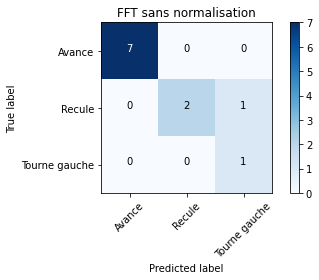

accuracy :  1.0


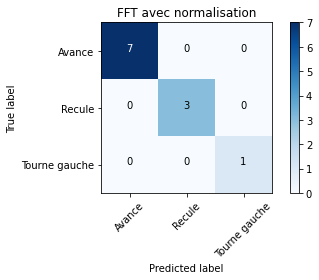

accuracy :  0.9090909090909091


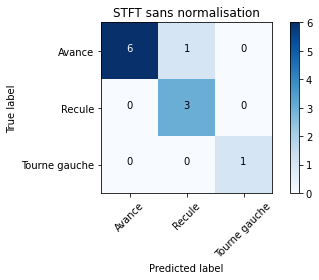

accuracy :  1.0


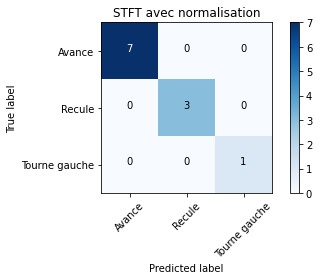

In [27]:
all_models = [model_fft_no_scale,
              model_fft_with_scale,
              model_stft_no_scale,
              model_stft_with_scale]
classes = ["Avance", "Recule", "Tourne gauche"]
model_names = [
    "FFT sans normalisation",
    "FFT avec normalisation",
    "STFT sans normalisation",
    "STFT avec normalisation",
]
for i, m in enumerate(all_models):
    pred = m.predict(X_test)
    score = accuracy_score(y_test, pred) 
    confusion = confusion_matrix(y_test, pred)
    print("accuracy : ", score)
    plt.imshow(confusion, cmap=plt.cm.Blues)
    plt.title(model_names[i])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Format and display the labels
    thresh = confusion.max() / 2.0
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            plt.text(j, i, format(confusion[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if confusion[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

##### The scaling/normalisation improve the accuracy of both fft and stft greatly. Despite the fact that we reduced the dimension of our problem, we got a very satisfying accurary and confusion matrix on the test data. It means that a lot of features in the initial signal were useless.


# Partie III : Classification par méthodes SVM à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 




In [28]:
from sklearn.svm import NuSVC

We first apply SVC on an ideal model to test the capacity of svc/svm models to classify the data.

In [29]:
from sklearn.svm import SVC

svm = SVC()

params = {
    "stft__statistic": [np.max],
    "stft__idx_frequence_max": [55],
    "svm__C": [10], # after testing np.logspace(-3, 1, 20)
    "svm__kernel": ["rbf"],
    "svm__gamma": [0.1],
    }
pipeline = Pipeline(steps = [("scaler", StandardScaler()), ("stft", STFT()), ('svm', svm)])
clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), verbose=1, n_jobs=-1)

model = clf.fit(X_train, y_train)

Fitting 172 folds for each of 1 candidates, totalling 172 fits


In [30]:
print(clf.best_params_)
print(clf.best_score_)

{'stft__idx_frequence_max': 55, 'stft__statistic': <function amax at 0x7f4928107d90>, 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
0.872093023255814


0.9090909090909091


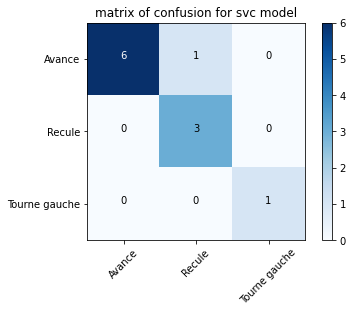

In [31]:
y_pred =clf.predict(X_test) 
print(accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test, y_pred)
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title("matrix of confusion for svc model")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                horizontalalignment="center",
                color="white" if confusion[i, j] > thresh else "black")


1 - Appliquez une pca + SVC rbf et créer une fonction qui plot les frontières de décisions.

To visualize the effects of the differents parameters, we project the results of svc on 2 dimensions (the 2 first principals components).

In [32]:
def draw_svc_boundaries(X, y, clf=None):
    h = 1.0
    previously_trained = clf is not None
    if not previously_trained:
        X_fft = FFT().transform(X)
        #X_scaled = StandardScaler().fit_transform(X_fft)
        X_pca = PCA(n_components=2).fit_transform(X_fft)
        clf = GridSearchCV(SVC(kernel="rbf", gamma=4e-6), param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1).fit(X_pca, y)
    else:
        X_pca = X
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="black")

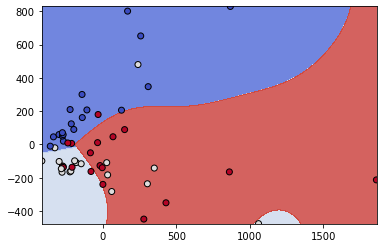

In [33]:
draw_svc_boundaries(X, y)

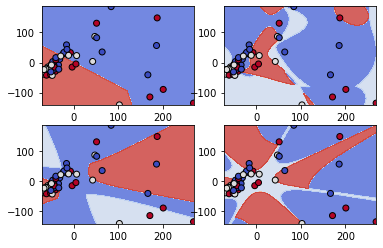

In [34]:
fig, axs = plt.subplots(2, 2)
kernels = [
    ("linear", 0),
    ("rbf", 0),
    ("poly", 2),
    ("poly", 4),
]
pipeline = Pipeline(steps = [("fft", FFT()), ("scaler", StandardScaler()), ("pca", PCA(n_components=2))])
X_features = pipeline.fit_transform(X)

for i, k in enumerate(kernels):
    svm = NuSVC(nu=0.1, kernel=k[0], degree=k[1])
    model = GridSearchCV(svm, param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1).fit(X_features, y).best_estimator_
    plt.subplot(2, 2, i+1)
    draw_svc_boundaries(X_features, y, clf=model)
    
plt.show()

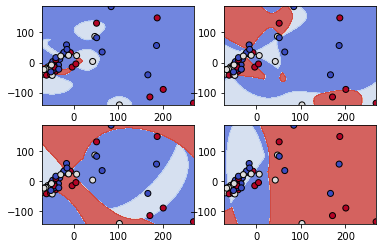

In [35]:
fig, axs = plt.subplots(2, 2)
gammas = [10**i for i in range(-3, -7, -1)]
pipeline = Pipeline(steps = [("fft", FFT()), ("scaler", StandardScaler()), ("pca", PCA(n_components=2))])
X_features = pipeline.fit_transform(X)

for i, g in enumerate(gammas):
    svm = NuSVC(nu=0.1, kernel="rbf", gamma=g)
    model = GridSearchCV(svm, param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1).fit(X_features, y).best_estimator_
    plt.subplot(2, 2, i+1)
    draw_svc_boundaries(X_features, y, clf=model)
    
plt.show()

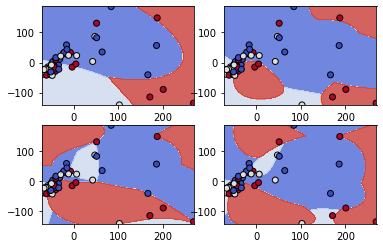

In [36]:
fig, axs = plt.subplots(2, 2)
Cs = [10**i for i in range(3, 10, 2)]
pipeline = Pipeline(steps = [("fft", FFT()), ("scaler", StandardScaler()), ("pca", PCA(n_components=2))])
X_features = pipeline.fit_transform(X)

for i, c in enumerate(Cs):
    svm = SVC(C=c, kernel="rbf", gamma=2e-6)
    model = GridSearchCV(svm, param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1).fit(X_features, y).best_estimator_
    plt.subplot(2, 2, i+1)
    draw_svc_boundaries(X_features, y, clf=model)
    
plt.show()

2 - Quelle est l'influence de $\gamma$ ? Justifiez.
 
 On remarque que pour $\gamma$ grand, le classifieur crée des régions autour de points individuels pour la classification, causant ainsi de l'overfitting. Dans le cas inverse, on remarque de l'underfitting. En lisant la documentation de la classe `SVC` de la bibliothèque `sklearn` on se rend compte que ce paramètre intervient dans le calcul du noyau de la `SVC`. Le paramètre $\gamma$ définit donc la portée d'influence de chaque exemple d'entraînement. Une valeur plus faible de $\gamma$ indique une portée d'influence plus étendue, ce qui signifie que les exemples d'entraînement ont une influence sur un plus grand nombre d'exemples de test, ce qui peut conduire à des frontières de décision plus douces et moins complexes.


3 - Quelle est l'influence du paramètre C ? Justifiez.

Pour le paramètre de régularisation `C`,  on remarque un effet sur la flexibilité des frontières de prédiction, plus ce paramètre est grand, plus l'erreur de classification a de l'importance dans le calcul de la fonction perte et donc le modèle s'ajuste plus aux données d'entraînement, auguementant le risque d'overfitting.

# Partie IV : Apprentissage par ensemble : Bootstrap Aggregation, Adaboost

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $L$ times to generate $L$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.



In [37]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

**Question 1 :**  Transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification


In [38]:
### 1. create y1
y1 = (y==1)


**Question 2 :**  Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.4, random_state=42)
np.random.seed(seed=42)
N = X_train.shape[0]
M=100
trees = []
trees_predict = []
for m in range(M):
    idx = np.random.choice(np.array([i for i in range(N)]), N)
    XB = X_train[idx]
    yB = y_train[idx]
    tree =  DecisionTreeClassifier(max_depth=2)
    tree = tree.fit(XB,yB)
    trees.append(tree)

# Predict
for tree in trees :
    tree_predict = tree.predict(X_test) 
    trees_predict.append(tree_predict)
    


In [40]:
# Vote
# Compter le nombre de True dans chaque tableau
counts = np.sum(trees_predict, axis=0)
fcom = counts > (M/2)
accuracy_fcom = accuracy_score(y_test, fcom)
accuracy_fcom

0.7727272727272727

In [41]:
# Comparision with the mean
accuracy_mean = (trees_predict == y_test).mean()
accuracy_mean

0.5745454545454546

On remarque que l'accuracy du bagging est supérieure à celle de la moyenne des modèles en raison de sa capacité à réduire la variance et à mieux généraliser. En utilisant des échantillons bootstrap et en agrégeant les prédictions de plusieurs modèles de base, le bagging permet de capturer une plus grande diversité de perspectives, ce qui améliore la robustesse des prédictions et la capacité à s'adapter à des données d'entraînement variées. 

**Question 3 :** Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?

In [42]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [43]:
X_scaled = StandardScaler().fit_transform(X)
X_stft = STFT(statistic=np.max, idx_frequence_max=55).transform(X_scaled)
params = {
    "criterion": ["gini"],
    "max_depth": [2],
    "min_samples_split": [3],
    "n_estimators": [50]
    }
clf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=LeaveOneOut(), n_jobs=-1)
clf.fit(X_stft, y)

GridSearchCV(cv=LeaveOneOut(), estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [2],
                         'min_samples_split': [3], 'n_estimators': [50]})

In [44]:
print(clf.best_params_)
print(clf.best_score_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 50}
0.7222222222222222


Oui, Random Forest est un modèle qui utilise la technique du bagging.
Random Forest crée un ensemble de plusieurs arbres de décision en utilisant des échantillons bootstrap de l'ensemble de données d'entraînement. Chaque arbre de décision est formé sur un échantillon bootstrap différent, et les prédictions de chaque arbre sont agrégées pour produire une prédiction finale.

En combinant les prédictions de multiples arbres formés sur des échantillons bootstrap et en introduisant de l'aléa dans la construction des arbres, Random Forest réduit la variance et le surajustement (overfitting) par rapport à un seul arbre de décision. Cela permet généralement d'obtenir de bonnes performances prédictives et une meilleure capacité à généraliser sur de nouvelles données.

On peut donc dire que Random Forest est un exemple de modèle bagging en utilisant un ensemble d'arbres de décision.

## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted
error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	\neq t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.


In [45]:

y1 = (y==1).astype(int)
y1[y1==0]=-1
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.4, random_state=42)
np.random.seed(seed=42)
N = X_train.shape[0]
weights = []

for i in range(N) :
    weights.append(1/N)
    
M=100
trees=[]
alphas = []
# Train
for m in range(M):
    tree =  DecisionTreeClassifier(max_depth=1)
    tree = tree.fit(X_train,y_train,sample_weight = weights)
    trees.append(tree)
    tree_predict = tree.predict(X_train) 
    em = np.dot((tree_predict!=y_train),weights) / np.sum(weights)
    alpha = np.log((1-em)/em)
    alphas.append(alpha)
    weigths = np.multiply(weights,np.exp(alpha*(tree_predict!=y_train)))

# Predict
trees_prediction = np.zeros((M,y_test.shape[0]))
for m in range(M):
    tree_prediction= trees[m].predict(X_test)
    trees_prediction[m] = tree_prediction 

Ym = np.matmul(alphas,trees_prediction)
Ym = np.sign(Ym)

accuracy = accuracy_score(y_test, Ym)
 

In [46]:
accuracy

0.7272727272727273

The accuracy of our implemented Adaboost is inferior than our implemented Bagging. 

**Question 2 :** 
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. 


In [47]:
from sklearn.ensemble import AdaBoostClassifier

In [48]:
X_scaled = StandardScaler().fit_transform(X)
X_stft = STFT(statistic=np.max, idx_frequence_max=55).transform(X_scaled)
params = {
    "algorithm" : ["SAMME","SAMME.R"],
    "n_estimators": range(50,301,50)
    }
clf = GridSearchCV(AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=2)), param_grid=params, cv=LeaveOneOut(), n_jobs=-1)
clf.fit(X_stft, y)

GridSearchCV(cv=LeaveOneOut(),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'n_estimators': range(50, 301, 50)})

In [49]:
clf.best_params_

{'algorithm': 'SAMME', 'n_estimators': 250}

In [50]:
clf.best_score_

0.7592592592592593

# Partie V : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [51]:
import torch
### transform X with your preprocessing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_train = STFT(statistic=np.max, idx_frequence_max=55).transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = STFT(statistic=np.max, idx_frequence_max=55).transform(X_test)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    
    

In [52]:
import torch.nn as nn

In [53]:
X_train.shape

torch.Size([27, 1, 55])

In [54]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            nn.Linear(55, 3),       
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.softmax(self.network(xb), dim=1)

In [55]:
model = NNClassification()
num_epochs = 200

result_test_loss = []
result_train_loss = []
result_test_acc = []
result_train_acc = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_acc = 0

    for i in range(X_train.shape[0]):
        model.zero_grad()
        pred = model(X_train[i])
        current_loss = loss(pred, y_train[i])
        current_loss.backward()
        optimizer.step()
        train_losses.append(current_loss.item())
        train_acc += torch.eq(y_train[i].argmax(), pred.argmax()).int()

    result_train_acc.append(train_acc / X_train.shape[0])

    model.eval()
    test_losses = []
    test_acc = 0

    for i in range(X_test.shape[0]):
        pred = model(X_test[i])
        current_loss = loss(pred, y_test[i])
        test_losses.append(current_loss.item())
        test_acc += torch.eq(y_test[i].argmax(), pred.argmax()).int()

    result_test_acc.append(test_acc / X_test.shape[0])

    result_train_loss.append(torch.mean(torch.tensor(train_losses)).item())
    result_test_loss.append(torch.mean(torch.tensor(test_losses)).item())


**Question 2:** Plot the train and test loss. What do you observe?

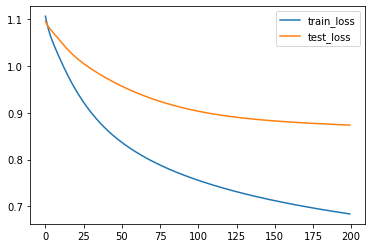

In [56]:
plt.plot(result_train_loss, label = "train_loss")
plt.plot(result_test_loss, label = "test_loss")
plt.legend()

We observe a decrease of the loss. But the test_loss > train_loss so it means that we have an overfitting.

**Question 3 :** Compute the accuracy.

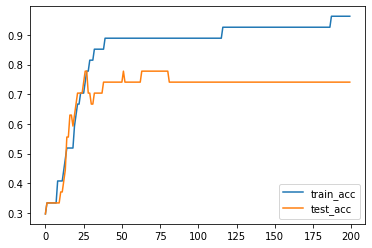

In [57]:
plt.plot(result_train_acc, label = "train_acc")
plt.plot(result_test_acc, label = "test_acc")
plt.legend()

**Question 4:** If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

In [58]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(55, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 3)
        )
    
    def forward(self, xb):
        return torch.softmax(self.network(xb), dim=1)


In [59]:
model = NNClassification()
num_epochs = 200

result_test_loss = []
result_train_loss = []
result_test_acc = []
result_train_acc = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_acc = 0

    for i in range(X_train.shape[0]):
        model.zero_grad()
        pred = model(X_train[i])
        current_loss = loss(pred, y_train[i])
        current_loss.backward()
        optimizer.step()
        train_losses.append(current_loss.item())
        train_acc += torch.eq(y_train[i].argmax(), pred.argmax()).int()

    result_train_acc.append(train_acc / X_train.shape[0])

    model.eval()
    test_losses = []
    test_acc = 0

    for i in range(X_test.shape[0]):
        pred = model(X_test[i])
        current_loss = loss(pred, y_test[i])
        test_losses.append(current_loss.item())
        test_acc += torch.eq(y_test[i].argmax(), pred.argmax()).int()

    result_test_acc.append(test_acc / X_test.shape[0])

    result_train_loss.append(torch.mean(torch.tensor(train_losses)).item())
    result_test_loss.append(torch.mean(torch.tensor(test_losses)).item())

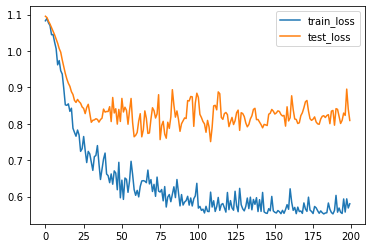

In [60]:
plt.plot(result_train_loss, label = "train_loss")
plt.plot(result_test_loss, label = "test_loss")
plt.legend()

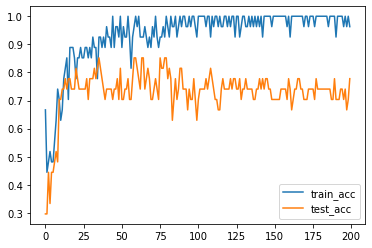

In [61]:
plt.plot(result_train_acc, label = "train_acc")
plt.plot(result_test_acc, label = "test_acc")
plt.legend()

Even after regularization, we don't have better results. We might have to change our architecture.

### CNN

In [62]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')
        
        self.outcov = nn.Conv1d(self.layer_n, 11, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        
        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)
        
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)
        
        x = torch.cat([out_1,pool_x1],1)
        out_2 = self.layer3(x)
        
        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)
        
        #############Decoder####################
        
        up = self.upsample1(x)
        up = torch.cat([up,out_2],1)
        up = self.cbr_up1(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_1],1)
        up = self.cbr_up2(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_0],1)
        up = self.cbr_up3(up)
        
        out = self.outcov(up)
        
        #out = nn.functional.softmax(out,dim=2)
        
        return out

In [63]:
device = torch.device('cuda') 
print(f"device : {device}")

device : cuda


In [64]:
from torch.utils.data import TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = augment_sound_samples(X_train, y_train, 3)
# Convertir les données en tenseurs PyTorch
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()


In [65]:
print(X_train.shape)

torch.Size([172, 18522])


In [69]:

model = UNET_1D(18522,128,7,3) 
model = model.to(device)
num_epochs = 10

result_test_loss = []
result_train_loss = []
result_test_acc = []
result_train_acc = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_acc = 0
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    for i in range(X_train.shape[0]):
        model.zero_grad()
        pred = model(X_train[i].unsqueeze(0).unsqueeze(0).to(device))
        current_loss = loss(pred, y_train[i].unsqueeze(0).to(device))
        current_loss.backward()
        optimizer.step()
        train_losses.append(current_loss.item())
        train_acc += torch.eq(y_train[i].argmax(), pred.argmax()).int()

    result_train_acc.append(train_acc / X_train.shape[0])

    

Epoch 1
-------------------------------


RuntimeError: Given groups=1, weight of size [128, 18522, 7], expected input[1, 1, 18522] to have 18522 channels, but got 1 channels instead

In [ ]:
model.eval()
    test_losses = []
    test_acc = 0

    for i in range(X_test.shape[0]):
        pred = model(X_test[i].unsqueeze(0).to(device))  # Ajoutez unsqueeze() pour ajouter une dimension de lot
        current_loss = loss(pred, y_test[i].unsqueeze(0).to(device))
        test_losses.append(current_loss.item())
        test_acc += torch.eq(y_test[i].argmax(), pred.argmax()).int()

    result_test_acc.append(test_acc / X_test.shape[0])

    result_train_loss.append(torch.mean(torch.tensor(train_losses)).item())
    result_test_loss.append(torch.mean(torch.tensor(test_losses)).item())